<a target="_blank" href="https://colab.research.google.com/github/wbfrench1/barker_DATA606/blob/main/src/crf_models/CRF_NER_Model_w_Grid_Search.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# Ran into the following error: AttributeError: 'CRF' object has no attribute 'keep_tempfiles'
# Used below resolution
#https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60
!pip install -U 'scikit-learn<0.24'
!pip install sklearn-crfsuite
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 36.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-0.23.2-cp39-cp39-linux_x86_64.whl size=24678696 sha256=0ed9c1f9c25478bd29e0171a167b55f6535437a2026a6077f043bef913d8df05
  Stored in directory: /root/.cache/pip/wheels/5e/74/24/7e235ccf01765c0daa089c98cc823e9dc1383da5fe0ed7e224
Successfully built scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requi

In [14]:
import os
!wget https://github.com/wbfrench1/barker_DATA606/blob/82bfc60080cf20e744254d180e8d7ac2b3205199/src/crf_models/crf_functions.py?raw=true
os.rename('/content/crf_functions.py?raw=true', '/content/crf_functions.py')

--2023-04-22 12:03:22--  https://github.com/wbfrench1/barker_DATA606/blob/82bfc60080cf20e744254d180e8d7ac2b3205199/src/crf_models/crf_functions.py?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wbfrench1/barker_DATA606/raw/82bfc60080cf20e744254d180e8d7ac2b3205199/src/crf_models/crf_functions.py [following]
--2023-04-22 12:03:22--  https://github.com/wbfrench1/barker_DATA606/raw/82bfc60080cf20e744254d180e8d7ac2b3205199/src/crf_models/crf_functions.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wbfrench1/barker_DATA606/82bfc60080cf20e744254d180e8d7ac2b3205199/src/crf_models/crf_functions.py [following]
--2023-04-22 12:03:22--  https://raw.githubusercontent.com/wbfrench1/barker_DATA606/82bfc60080cf20e744254d180e8d7ac2b3205199/src/crf_m

In [15]:
import eli5
import crf_functions as funcs
from google.colab import drive
import requests
import pandas as pd
import random
import numpy as np
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
import joblib
from sklearn_crfsuite import metrics as crf_metrics
import nltk
nltk.download('averaged_perceptron_tagger')
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import pickle

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 1. Read in the Data

##   1.a. Read in the Sarkar data
##   1.b. Read in the movie data


In [3]:
df = pd.read_csv('https://github.com/wbfrench1/barker_DATA606/blob/05c1c56275fcaf7e4df300b578f65f62127dad18/data/movie_data.csv?raw=true')

# 2. Explore the Data

In [4]:
# Differentiate the question columns.  q_num is absoloute, while
## q_num_by_src is a numbering for each of the four, movie data
### sets
df.rename(columns={'quest_num':'q_num_by_src',
                   'label': 'postag',
                   'entity' : 'tag'}, inplace=True)

In [5]:
df.head()

,q_num_by_src,postag,word,pos,tag,source,q_num
0,1,o-outside,what,o,outside,eng_train,1
1,1,o-outside,movies,o,outside,eng_train,1
2,1,o-outside,star,o,outside,eng_train,1
3,1,b-actor,bruce,b,actor,eng_train,1
4,1,i-actor,willis,i,actor,eng_train,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322035 entries, 0 to 322034
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   q_num_by_src  322035 non-null  int64 
 1   postag        322035 non-null  object
 2   word          322034 non-null  object
 3   pos           322035 non-null  object
 4   tag           322035 non-null  object
 5   source        322035 non-null  object
 6   q_num         322035 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 17.2+ MB


In [54]:
df.tag.unique()

array(['outside', 'actor', 'year', 'title', 'genre', 'director', 'song',
       'plot', 'review', 'character', 'rating', 'trailer', 'award',
       'origin', 'relationship', 'quote'], dtype=object)

In [8]:
df.tag.value_counts()

outside         145975
plot             89414
actor            22326
genre            13479
year             10246
director          8798
rating            7969
title             7289
origin            5117
character         3187
relationship      2246
review            2141
quote             1339
award             1241
song              1110
trailer            158
Name: tag, dtype: int64

In [10]:
df['q_num'].nunique(), df['word'].nunique(), df['pos'].nunique(), df['tag'].nunique()

(21987, 15336, 3, 16)

# 3. Create features in the data

In [ ]:
def word2features(l_sent: list, i) -> dict:

    '''   Description:  Takes a list of sentence tuples and an integer 
                        identifying the word the function will work on and
                        returns a dictionary containing the words in
                        each sentence and corresponding features.
                        
                        l_sents: is formatted as a list of tuples where each 
                                 tuple is a:
                                   word in the sentence, 
                                   a part of speech tag,
                                   and an NER tag

                                   (word:str, POS:str, NER:str)
        
          Returns:      a dictionary, where each dictionary contains
                        features for one word in one sentence.
    
    '''
    word = l_sent[i][0]
    postag = l_sent[i][1]

    features = {'bias': 1.0,
                'word.lower()': word.lower(),
                'word[-3:]': word[-3:],
                'word[-2:]': word[-2:],
                'word.isupper': word.isupper(),
                'word.istitle()': word.istitle(),
                'word.isdigit()': word.isdigit(),
                'postag': postag,
                'postag[:2]': postag[:2]
                }
    
    if i > 0:
        word1 = l_sent[i - 1][0]
        postag1 = l_sent[i - 1][1]
        features.update( {'-1:word.lower()': word1.lower(),
                          '-1:word.istitle()': word1.istitle(),
                          '-1:word.isupper': word1.isupper(),
                          '-1:postag': postag1,
                          '-1:postag[:2]': postag1[:2]
                          }
                        )
    
    else:
        features['BOS'] = True

    if i < len(l_sent) - 1:
        word1 = l_sent[i + 1][0]
        postag1 = l_sent[i + 1][1]
        features.update({'+1:word.lower()': word1.lower(),
                         '+1:word.istitle()': word1.istitle(),
                         '+1:word.isupper': word1.isupper(),
                         '+1:postag': postag1,
                         '+1:postag[:2]': postag1[:2]
                         }
                        )
    else:
        features['EOS'] = True
    
    return features

In [ ]:
def sent2features(l_sent:list ) -> list:
    '''   Description:  Takes a sentence as a list of word tuples and returns a
                        list of dictionaries. The list contains tuples of
                        sentences, where each tuple is broken up into a word in
                        the sentence, a part of speech tag, and an NER tag.  
                        
                        l_sents: is formatted as a list of tuples where each 
                                 tuple contains a word in the sentence, the 
                                 word's part of speech tag, and an NER tag:  
                                 (word:str, POS:str, NER:str)
        
          Returns:      list of dictionaries of word features
    
    '''

    return [ word2features(l_sent, i) for i in range(len(l_sent))]

In [ ]:
def sent2labels(l_sent: list) -> list:
    '''   Description:  Takes a list of sentence word tuples and returns the ner 
                        label from each word tuple. 
                        
                        l_sents is formatted as a list of tuples where each 
                                 tuple contains a word in the sentence, the 
                                 word's part of speech tag, and an NER tag:  
                                 (word:str, POS:str, NER:str)

          Returns:      list of dictionaries of word features
    
    '''

    return [label for token, postag, label in l_sent]

# 4. Implement Model for Movie Data

## 4.1 Convert Movie Data Format

In [17]:
df.head()

,q_num_by_src,postag,word,pos,tag,source,q_num
0,1,o-outside,what,o,outside,eng_train,1
1,1,o-outside,movies,o,outside,eng_train,1
2,1,o-outside,star,o,outside,eng_train,1
3,1,b-actor,bruce,b,actor,eng_train,1
4,1,i-actor,willis,i,actor,eng_train,1


In [18]:
# copy original data
df1 = df.copy()

In [19]:
df1.columns

Index(['q_num_by_src', 'postag', 'word', 'pos', 'tag', 'source', 'q_num'], dtype='object')

In [20]:
# remove the extra columns
df1.drop(columns=['q_num_by_src', 'pos', 'tag', 'source'], inplace=True)

In [21]:
df1.head()

,postag,word,q_num
0,o-outside,what,1
1,o-outside,movies,1
2,o-outside,star,1
3,b-actor,bruce,1
4,i-actor,willis,1


In [22]:
#convert the word format to string
#rename the columns to match the Sarkar Tool
df1.word = df1.word.astype(str)
df1.rename(columns={'q_num': 'Sentence #',
                    'word': 'Word',
                    'postag': 'Tag'}, inplace=True)

In [23]:
# check for null values
df1.loc[df1.Word.isnull()]

,Tag,Word,Sentence #


In [24]:
df1.dropna(inplace=True)

In [25]:
# create the part of speech (POS) variable
df1['POS'] = [pos for word, pos in nltk.pos_tag(df1['Word'])]

In [26]:
df1.head()

,Tag,Word,Sentence #,POS
0,o-outside,what,1,WP
1,o-outside,movies,1,NNS
2,o-outside,star,1,VBP
3,b-actor,bruce,1,NN
4,i-actor,willis,1,NN


In [28]:
# update the 'o-outside tag to o
df1['Tag'].replace({'o-outside': 'o'}, inplace=True)

In [29]:
df1.head()

,Tag,Word,Sentence #,POS
0,o,what,1,WP
1,o,movies,1,NNS
2,o,star,1,VBP
3,b-actor,bruce,1,NN
4,i-actor,willis,1,NN


In [31]:
agg_func = lambda s: [(w,p,t) for w, p, t in zip(s['Word'].values.tolist(),
                                                 s['POS'].values.tolist(),
                                                 s['Tag'].values.tolist()
                                                 )
                                                 ]

In [32]:
# create the initial data format list of tuples (Word, POS, Tag)
grouped_df1 = df1.groupby('Sentence #').apply(agg_func)
l_sentences = [s for s in grouped_df1]

In [33]:
# view the list of sentence lists, where each sentence is a list of word tuples
# in the order of the original sentence. 
l_sentences[0]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [35]:
# make the feature set
X = np.array([funcs.sent2features(s) for s in l_sentences], dtype=object)
# make the label set
y = np.array([funcs.sent2labels(s) for s in l_sentences], dtype=object)

In [41]:
# view the resulting feature of the first sentences first word
X[0][0]

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 42)
X_train.shape, X_test.shape

((17589,), (4398,))

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import scipy.stats
from collections import Counter

In [80]:
labels = list(df1.Tag.unique())

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [ ]:
param_grid = [{'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]]
param_grid

In [63]:
param_grid = {'c1': scipy.stats.expon(scale=0.5),
              'c2': scipy.stats.expon(scale=0.05),
}
param_grid

{'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fc8d541d4f0>,
 'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fc8d4efd3a0>}

In [82]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
# define the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=50,
    all_possible_transitions=True
)

# define the scoring metric
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [85]:
# create the randomized search
rs = RandomizedSearchCV(crf, param_grid,
                        cv=2,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=3,
                        scoring=f1_scorer)

In [86]:
# search for the best regularization parameters
rs.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.3min finished


RandomizedSearchCV(cv=2,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=50),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc8d541d4f0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc8d4efd3a0>},
                   scoring=make_sco...=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote']),
                   verbose=1)

In [88]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.1895122714190105, 'c2': 0.0570615152905861}
best CV score: 0.8578180962362314
model size: 3.80M


In [89]:
rs.cv_results_

{'mean_fit_time': array([76.73994756, 77.68374991, 76.56080472]),
 'std_fit_time': array([0.89762783, 1.22006011, 0.19984758]),
 'mean_score_time': array([5.43666613, 5.37965679, 3.51191282]),
 'std_score_time': array([1.21734798, 1.15648246, 1.26948571]),
 'param_c1': masked_array(data=[0.1895122714190105, 0.6152809279801799,
                    0.40792979136574437],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_c2': masked_array(data=[0.0570615152905861, 0.057749088822697706,
                    0.01855649889089143],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'c1': 0.1895122714190105, 'c2': 0.0570615152905861},
  {'c1': 0.6152809279801799, 'c2': 0.057749088822697706},
  {'c1': 0.40792979136574437, 'c2': 0.01855649889089143}],
 'split0_test_score': array([0.85559046, 0.85351636, 0.8534617 ]),
 'split1_test_score': array([0.86004574, 0.86047061, 0.85982657]),
 'mean_t

Dark blue => 0.8566, dark red => 0.8578


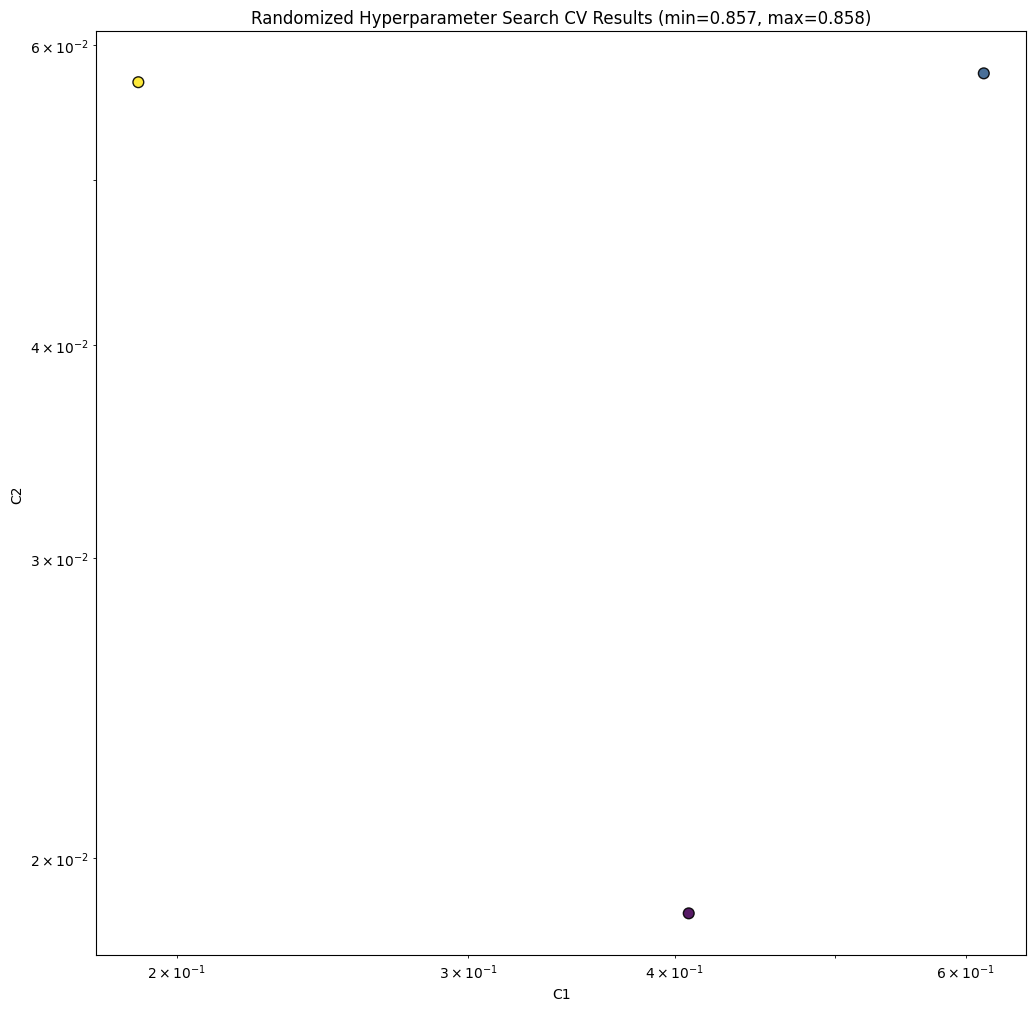

In [90]:
#https://stackoverflow.com/questions/61722752/attributeerror-randomizedsearchcv-object-has-no-attribute-grid-scores
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [91]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                precision    recall  f1-score   support

             o      0.899     0.907     0.903     29657
       b-actor      0.921     0.930     0.926      2065
       i-actor      0.921     0.928     0.925      2417
       b-award      0.568     0.525     0.545        80
       i-award      0.655     0.692     0.673       195
   b-character      0.715     0.440     0.545       359
   i-character      0.697     0.487     0.573       269
    b-director      0.859     0.825     0.842       864
    i-director      0.874     0.834     0.853       880
       b-genre      0.887     0.883     0.885      1928
       i-genre      0.782     0.729     0.754       708
      b-origin      0.411     0.296     0.344       179
      i-origin      0.637     0.617     0.626       733
        b-plot      0.502     0.458     0.479      2027
        i-plot      0.854     0.911     0.882     14978
       b-quote      0.533     0.258     0.348        31
       i-quote      0.637     0.391     0.485  

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

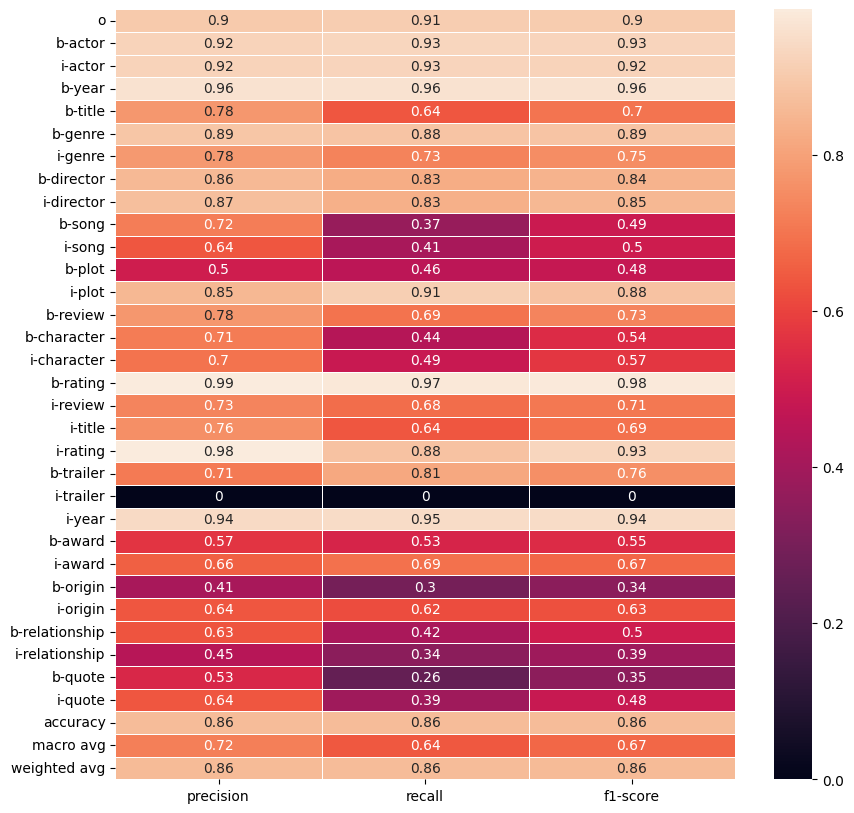

In [100]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)

In [99]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
i-song -> i-song  6.678912
b-song -> i-song  6.623759
b-origin -> i-origin 6.396950
i-origin -> i-origin 6.235651
b-title -> i-title 6.003217
i-relationship -> i-relationship 5.571336
b-actor -> i-actor 5.533003
b-director -> i-director 5.531364
i-title -> i-title 5.529734
i-plot -> i-plot  5.525668
i-quote -> i-quote 5.385240
b-relationship -> i-relationship 5.356188
i-year -> i-year  5.245745
b-character -> i-character 5.004146
b-quote -> i-quote 4.973391
i-genre -> i-genre 4.916115
b-plot -> i-plot  4.788665
i-review -> i-review 4.556898
b-genre -> i-genre 4.554838
i-character -> i-character 4.536156

Top unlikely transitions:
b-plot -> b-plot  -4.647508
i-genre -> b-genre -4.760610
i-actor -> i-plot  -4.872178
i-plot -> i-quote -4.982657
o      -> i-award -5.018490
o      -> i-rating -5.125572
i-plot -> i-character -5.146438
o      -> i-origin -5.305658
o      -> i-relationship -5.455474
o      -> i-genre -5.525335
o      -> i-director -5.587150
i-plot -> b-

In [97]:
#https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2
eli5.show_weights(crf, top=5)

From \ To,o,b-actor,i-actor,b-award,i-award,b-character,i-character,b-director,i-director,b-genre,i-genre,b-origin,i-origin,b-plot,i-plot,b-quote,i-quote,b-rating,i-rating,b-relationship,i-relationship,b-review,i-review,b-song,i-song,b-title,i-title,b-trailer,i-trailer,b-year,i-year
o,2.124,1.225,-6.343,0.419,-5.018,0.832,-5.714,0.889,-5.587,0.712,-5.525,0.887,-5.306,0.942,-7.577,0.449,-5.703,0.552,-5.126,0.445,-5.455,1.065,-6.252,0.978,-3.933,0.973,-5.881,-0.179,-4.412,0.751,-6.367
b-actor,-0.65,-3.0,5.533,-0.622,-1.957,-2.231,-2.561,-1.171,-2.822,-1.74,-1.487,-1.181,-1.632,-0.444,-3.294,-1.232,-1.553,-1.336,-0.949,-1.553,-1.376,-0.944,-2.131,-0.881,-0.709,-2.422,-1.979,-0.659,-0.364,-1.205,-1.206
i-actor,0.804,-4.624,3.324,0.01,-2.63,-1.834,-3.151,-3.419,-2.976,0.749,-2.452,-0.511,-2.511,0.863,-4.872,-1.715,-3.24,0.0,-2.1,-1.473,-2.521,0.113,-3.497,-0.386,-1.902,-2.473,-2.185,-0.898,-1.472,0.668,-2.089
b-award,-0.14,-1.041,-1.144,-0.038,4.373,-0.598,-0.593,-0.865,-0.739,-2.274,-0.501,-0.359,-0.406,-2.002,-1.899,-0.007,-0.293,-0.743,-0.091,-0.02,-0.327,-0.956,-0.952,-0.022,-0.001,-0.793,-0.536,-0.003,0.0,-0.015,-0.651
i-award,0.035,-0.194,-1.481,-0.144,4.302,-0.745,-0.764,-0.007,-1.317,-0.511,-1.164,0.076,-1.033,-1.376,-2.236,-0.029,-0.488,-0.51,-0.517,0.148,-0.647,-0.055,-1.131,-0.003,-0.129,-1.162,-1.003,-0.007,-0.0,-0.132,-0.816
b-character,-0.152,-1.405,-2.818,-0.465,-1.075,-2.387,5.004,-1.899,-2.374,-2.571,-1.316,-1.042,-1.354,1.844,-3.44,-0.58,-1.166,-1.065,-0.815,-0.819,-1.508,-2.213,-2.045,-0.65,-0.727,-1.558,-1.966,-0.535,-0.017,-1.386,-0.968
i-character,0.159,-0.671,-2.297,-0.415,-0.702,-1.376,4.536,-1.616,-1.489,-0.665,-0.948,-0.806,-1.18,1.654,-3.717,0.018,-0.834,-1.052,-0.737,-0.003,-1.36,-0.47,-2.184,-0.429,-0.492,-2.026,-2.3,-0.12,-0.003,-1.426,-1.101
b-director,-0.013,-2.648,-3.646,-0.559,-1.641,-1.512,-2.499,-2.899,5.531,-0.092,-2.075,-0.095,-1.694,-1.541,-2.774,-1.349,-1.685,-1.703,-1.3,0.019,-1.798,0.051,-2.047,-1.048,-0.755,0.011,-1.973,-0.606,-0.377,-0.133,-1.098
i-director,0.763,-1.86,-2.973,0.001,-2.93,-1.423,-2.405,-2.103,3.458,1.298,-2.319,-0.011,-2.053,-0.229,-3.346,-1.515,-1.849,0.076,-1.251,0.28,-1.809,0.494,-2.41,-1.323,-0.989,-1.69,-1.724,-0.616,-0.434,0.7,-1.675
b-genre,0.677,0.129,-3.543,0.0,-2.247,-1.674,-2.332,0.441,-2.971,-5.714,4.555,0.849,-2.078,0.375,-3.712,-1.374,-1.72,0.299,-1.806,0.752,-2.448,0.895,-3.068,-1.441,-1.355,-1.866,-2.313,-1.053,-0.924,0.815,-1.683


In [42]:
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1= 0.1, c2= 0.1, max_iterations= 100, all_possible_transitions= True, verbose= True)
crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|██████████| 17589/17589 [00:05<00:00, 3058.71it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 94459
Seconds required: 1.338

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=2.69  loss=694261.76 active=92853 feature_norm=1.00
Iter 2   time=4.07  loss=485210.00 active=91622 feature_norm=3.73
Iter 3   time=1.93  loss=444686.81 active=87930 feature_norm=3.87
Iter 4   time=2.22  loss=412101.25 active=91501 feature_norm=3.48
Iter 5   time=1.33  loss=397659.62 active=91873 feature_norm=3.63
Iter 6   time=1.68  loss=380573.80 active=92478 feature_norm=4.16
Iter 7   time=1.35  loss=353026.74 active=93191 feature_norm=4.34
Iter 8   time=1.34  loss=299256.05 active=92492 feature_norm=5.94
Iter 9   time=1.33  loss=285331.21 active=92738 feature_norm=7.24
Iter 

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100, verbose=True)

In [ ]:
#joblib.dump(crf, '/content/drive/MyDrive/Colab Notebooks/0. Data 606 - Capstone/Models/crf_ner_movie_model.pkl')

In [ ]:
y_pred = crf.predict(X_test)

In [79]:
labels = crf.classes_

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)


In [ ]:
if 'o-outside' in labels:
    labels.remove('o-outside')
str_class_report = (crf_metrics.flat_classification_report(y_test,y_pred, labels=labels))
print(str_class_report)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-genre', 'b-director', 'i-director', 'b-title', 'i-title', 'b-year', 'i-genre', 'b-award', 'i-award', 'b-review', 'b-plot', 'i-plot', 'i-review', 'b-rating', 'i-rating', 'b-actor', 'i-actor', 'b-relationship', 'i-year', 'b-character', 'i-character', 'i-relationship', 'b-origin', 'i-origin', 'b-quote', 'i-quote', 'b-song', 'i-song', 'b-trailer', 'i-trailer'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

             o       0.91      0.90      0.91     36962
       b-genre       0.89      0.89      0.89      2416
    b-director       0.87      0.83      0.85      1076
    i-director       0.90      0.83      0.87      1096
       b-title       0.81      0.68      0.74       735
       i-title       0.83      0.65      0.73      1082
        b-year       0.96      0.96      0.96      1722
       i-genre       0.75      0.73      0.74       876
       b-award       0.60      0.52      0.56       110
       i-award       0.66      0.71      0.69       267
      b-review       0.78      0.71      0.74       935
        b-plot       0.50      0.48      0.49      2565
        i-plot       0.84      0.92      0.88     19162
      i-review       0.74      0.71      0.73       725
      b-rating       0.98      0.97      0.98       647
      i-rating       0.96      0.86      0.91       278
       b-actor       0.92      0.94      0.93  

In [ ]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

In [ ]:
df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

,precision,recall,f1-score,support
o,0.908528,0.901818,0.905161,36962.0
b-genre,0.890586,0.892798,0.891691,2416.0
b-director,0.874140,0.826208,0.849498,1076.0
i-director,0.904055,0.833942,0.867584,1096.0
b-title,0.810373,0.680272,0.739645,735.0


<Axes: >

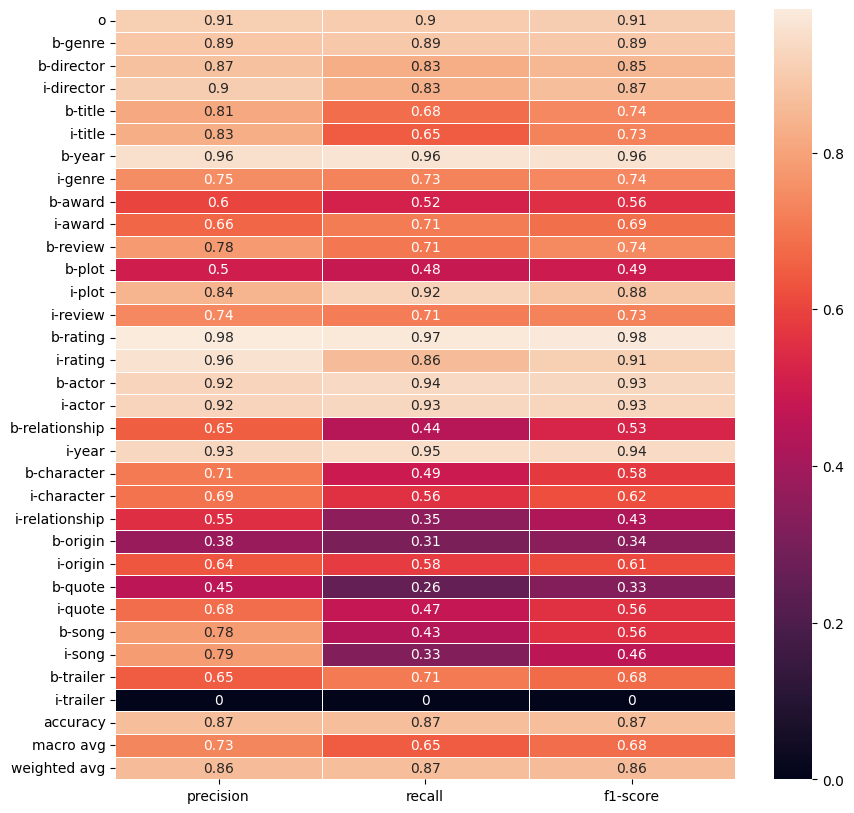

In [ ]:
# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)

# Word2Vec Features

In [ ]:
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
l_sents = [[tup[0] for tup in l_sent] for l_sent in l_sentences[0:]]

In [ ]:
l_sents[0]

['what', 'movies', 'star', 'bruce', 'willis']

In [ ]:
feature_size = 10
window_context = 30
min_word_count = 1
sample = 1e-3

In [ ]:
word2vec.Word2Vec()

In [ ]:
w2v_model = word2vec.Word2Vec(l_sents, 
                  vector_size= feature_size,
                  window = window_context,
                  min_count= min_word_count,
                  sample = sample,
                  )

In [ ]:
w2v_model.wv['what']

array([-0.74624395, -2.0799072 ,  2.7820344 ,  2.3366523 ,  0.8598433 ,
       -2.438018  ,  4.426962  ,  2.5536156 , -3.4388788 ,  0.58279073],
      dtype=float32)

In [ ]:
w2v_model.wv.get_normed_vectors()

array([[ 0.3485286 ,  0.19099167,  0.21500267, ...,  0.15718336,
        -0.6853779 , -0.02767766],
       [ 0.1644625 ,  0.12457786,  0.31098494, ...,  0.02415733,
        -0.58021986, -0.24330224],
       [ 0.1401228 ,  0.18386719,  0.26360768, ...,  0.08248157,
        -0.74818116, -0.04645745],
       ...,
       [-0.4139171 , -0.0938723 ,  0.22036943, ..., -0.31681028,
        -0.33627483,  0.2530463 ],
       [-0.18095791,  0.19722268, -0.04799867, ...,  0.28897056,
        -0.4697312 , -0.19120072],
       [ 0.20157555, -0.4232857 , -0.26113537, ..., -0.44267875,
        -0.03474994, -0.12938505]], dtype=float32)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
l_vectors = []

for word in w2v_model.wv.index_to_key:
    l_vectors.append(w2v_model.wv.get_vector(word))

In [ ]:
l_num_clus = []
l_silhouette_scores = []

for num_clus in [10, 20, 50, 100, 250, 500, 1000]:
    print(num_clus)
    kmeans = KMeans(n_clusters= num_clus)
    kmeans.fit_predict(l_vectors)
    l_num_clus.append(num_clus)
    l_silhouette_scores.append(silhouette_score(l_vectors, kmeans.labels_))

10
20
50
100
250
500
1000


In [ ]:
# create a word to cluster dictionary

# create a list to hold the words in the word2vec object
l_word_to_cluster = []
for word in w2v_model.wv.index_to_key:
    l_word_to_cluster.append(word)

dict_word_cluster = dict(zip(l_word_to_cluster,l_silhouette_scores))

In [ ]:
kmeans.

1000

In [ ]:
dict_word_cluster

{'the': 0.48699227,
 'a': 0.30858973,
 'movie': 0.099854395,
 'what': 0.07514213,
 'in': 0.0404902,
 'is': 0.03207697,
 'of': 0.031650122}

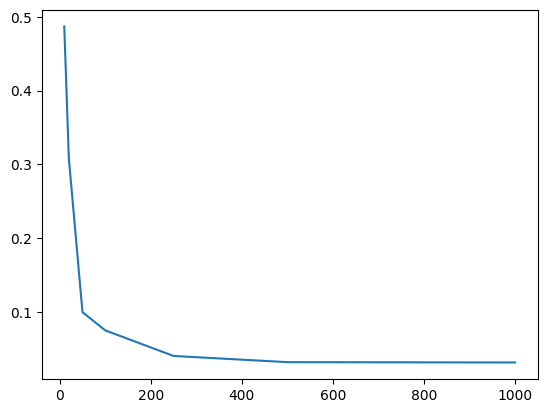

In [ ]:
import matplotlib.pyplot as plt
plt.plot(l_num_clus,l_silhouette_scores)

In [ ]:
w2v_model.wv.similarity('fire', 'star')

0.6647839

In [ ]:
def create_w2v_feature_dict (word2vec_model, word):
    dict_w2v = {}
    for sub_feat_num in range(len(word2vec_model.wv[word])):
        dict_w2v.update({'w2v_' + str(sub_feat_num): word2vec_model.wv[word][sub_feat_num]})
    return dict_w2v

In [ ]:
w2v_model.wv.most_similar('bruce')

[('morgan', 0.9906564354896545),
 ('beatty', 0.9891349673271179),
 ('freeman', 0.9868821501731873),
 ('weaver', 0.98685222864151),
 ('fisher', 0.9867677092552185),
 ('wrote', 0.9863390326499939),
 ('l', 0.9861729145050049),
 ('penn', 0.9826823472976685),
 ('statham', 0.9811477065086365),
 ('al', 0.9803164601325989)]

# Word2Vec: Create features in the data include W2V

In [ ]:
def word2features_w2v(l_sent: list, i, word2vec_model) -> dict:

    '''   Description:  Takes a sentence represented as a list of word tuples 
                        and an integer identifying the word tuple the function
                        will work on and returns a dictionary containing the 
                        words in each sentence and the corresponding features.
                        
                        l_sent: is formatted as a list of tuples where each 
                                 tuple is a:
                                   word in the sentence, 
                                   a part of speech tag,
                                   and an NER tag

                                   (word:str, POS:str, NER:str)
        
          Returns:      a dictionary, where each dictionary contains
                        features for one word in one sentence.
    
    '''
    word = l_sent[i][0]
    postag = l_sent[i][1]

    features = {'bias': 1.0,
                'word.lower()': word.lower(),
                'word[-3:]': word[-3:],
                'word[-2:]': word[-2:],
                'word.isupper': word.isupper(),
                'word.istitle()': word.istitle(),
                'word.isdigit()': word.isdigit(),
                'postag': postag,
                'postag[:2]': postag[:2],
               }
    
    features.update( create_w2v_feature_dict(w2v_model, word) )

    if i > 0:
        word1 = l_sent[i - 1][0]
        postag1 = l_sent[i - 1][1]
        features.update( {'-1:word.lower()': word1.lower(),
                          '-1:word.istitle()': word1.istitle(),
                          '-1:word.isupper': word1.isupper(),
                          '-1:postag': postag1,
                          '-1:postag[:2]': postag1[:2]
                          }
                        )
    
    else:
        features['BOS'] = True

    if i < len(l_sent) - 1:
        word1 = l_sent[i + 1][0]
        postag1 = l_sent[i + 1][1]
        features.update({'+1:word.lower()': word1.lower(),
                         '+1:word.istitle()': word1.istitle(),
                         '+1:word.isupper': word1.isupper(),
                         '+1:postag': postag1,
                         '+1:postag[:2]': postag1[:2]
                         }
                        )
    else:
        features['EOS'] = True
    
    return features

In [ ]:
def sent2features_w2v(l_sent:list, word2vec_model ) -> list:
    '''   Description:  Takes a sentence as a list of word tuples and returns a
                        list of dictionaries. The list contains tuples of
                        sentences, where each tuple is broken up into a word in
                        the sentence, a part of speech tag, and an NER tag.  
                        
                        l_sents: is formatted as a list of tuples where each 
                                 tuple contains a word in the sentence, the 
                                 word's part of speech tag, and an NER tag:  
                                 (word:str, POS:str, NER:str)
        
          Returns:      list of dictionaries of word features
    
    '''

    return [ word2features_w2v(l_sent, i, word2vec_model) for i in range(len(l_sent))]

In [ ]:
def sent2labels(l_sent: list) -> list:
    '''   Description:  Takes a list of sentence word tuples and returns the ner 
                        label from each word tuple. 
                        
                        l_sents is formatted as a list of tuples where each 
                                 tuple contains a word in the sentence, the 
                                 word's part of speech tag, and an NER tag:  
                                 (word:str, POS:str, NER:str)

          Returns:      list of dictionaries of word features
    
    '''

    return [label for token, postag, label in l_sent]

In [ ]:
grouped_df = df_ex.groupby('Sentence #').apply(agg_func)

In [ ]:
grouped_df.head()

Sentence #
Sentence: 1        [(Thousands, NNS, O), (of, IN, O), (demonstrat...
Sentence: 10       [(Iranian, JJ, B-gpe), (officials, NNS, O), (s...
Sentence: 100      [(Helicopter, NN, O), (gunships, NNS, O), (Sat...
Sentence: 1000     [(They, PRP, O), (left, VBD, O), (after, IN, O...
Sentence: 10000    [(U.N., NNP, B-geo), (relief, NN, O), (coordin...
dtype: object

In [ ]:
type(grouped_df1)

pandas.core.series.Series

In [ ]:
#grouped_df is a series NOT a dataframe
#each entry in the series is a list
# the elements in the list are tuples, 
#        - first entry is a sentence word
#        - second entry is a POS tag
#        - third entry is a IOB tag
grouped_df1[1]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [ ]:
# Standard tokenized sentence with POS and NER tags
# list of lists of tuples, where the list contains sentences reprsented as lists.
# Each sentence list contains a word in the sentence along with the POS and NER
l_sentences = [s for s in grouped_df1]
l_sentences[0]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [ ]:
word2features_w2v(l_sentences[0], 0, w2v_model)

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'w2v_0': -0.74624395,
 'w2v_1': -2.0799072,
 'w2v_2': 2.7820344,
 'w2v_3': 2.3366523,
 'w2v_4': 0.8598433,
 'w2v_5': -2.438018,
 'w2v_6': 4.426962,
 'w2v_7': 2.5536156,
 'w2v_8': -3.4388788,
 'w2v_9': 0.58279073,
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [ ]:
# make the feature set
X = np.array([sent2features_w2v(s, w2v_model) for s in l_sentences], dtype=object)
# make the label set
y = np.array([sent2labels(s) for s in l_sentences], dtype=object)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape

((16490,), (5497,))

In [ ]:
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1= 0.1, c2= 0.1, max_iterations= 100, all_possible_transitions= True, verbose= True)
crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|██████████| 16490/16490 [00:06<00:00, 2700.08it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 91509
Seconds required: 1.470

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=2.43  loss=533969.86 active=90028 feature_norm=1.00
Iter 2   time=1.22  loss=479375.01 active=87609 feature_norm=1.26
Iter 3   time=1.21  loss=453219.31 active=89020 feature_norm=1.58
Iter 4   time=1.20  loss=399874.22 active=88451 feature_norm=2.30
Iter 5   time=2.43  loss=384878.89 active=90303 feature_norm=2.98
Iter 6   time=1.61  loss=348582.20 active=90506 feature_norm=3.13
Iter 7   time=2.06  loss=335806.67 active=90569 feature_norm=3.63
Iter 8   time=1.28  loss=318625.75 active=90710 feature_norm=3.81
Iter 9   time=1.22  loss=305087.56 active=90630 feature_norm=4.28
Iter 

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100, verbose=True)

In [ ]:
joblib.dump(crf, 'crf_ner_movie_model.pkl')

['crf_ner_movie_model.pkl']

In [ ]:
y_pred = crf.predict(X_test)

In [ ]:
labels = crf.classes_
labels

['o',
 'b-genre',
 'b-director',
 'i-director',
 'b-title',
 'i-title',
 'b-year',
 'i-genre',
 'b-award',
 'i-award',
 'b-review',
 'b-plot',
 'i-plot',
 'i-review',
 'b-rating',
 'i-rating',
 'b-actor',
 'i-actor',
 'b-relationship',
 'i-year',
 'b-character',
 'i-character',
 'i-relationship',
 'b-origin',
 'i-origin',
 'b-quote',
 'i-quote',
 'b-song',
 'i-song',
 'b-trailer',
 'i-trailer']

In [ ]:
if 'o-outside' in labels:
    labels.remove('o-outside')
str_class_report = (crf_metrics.flat_classification_report(y_test,y_pred, labels=labels))
print(str_class_report)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-genre', 'b-director', 'i-director', 'b-title', 'i-title', 'b-year', 'i-genre', 'b-award', 'i-award', 'b-review', 'b-plot', 'i-plot', 'i-review', 'b-rating', 'i-rating', 'b-actor', 'i-actor', 'b-relationship', 'i-year', 'b-character', 'i-character', 'i-relationship', 'b-origin', 'i-origin', 'b-quote', 'i-quote', 'b-song', 'i-song', 'b-trailer', 'i-trailer'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


                precision    recall  f1-score   support

             o       0.91      0.90      0.91     36962
       b-genre       0.89      0.89      0.89      2416
    b-director       0.86      0.84      0.85      1076
    i-director       0.89      0.85      0.87      1096
       b-title       0.79      0.72      0.75       735
       i-title       0.77      0.68      0.73      1082
        b-year       0.96      0.96      0.96      1722
       i-genre       0.76      0.73      0.74       876
       b-award       0.59      0.52      0.55       110
       i-award       0.69      0.74      0.71       267
      b-review       0.77      0.71      0.74       935
        b-plot       0.50      0.48      0.49      2565
        i-plot       0.84      0.92      0.88     19162
      i-review       0.72      0.72      0.72       725
      b-rating       0.98      0.97      0.98       647
      i-rating       0.95      0.87      0.91       278
       b-actor       0.92      0.94      0.93  

In [ ]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

In [ ]:
df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

,precision,recall,f1-score,support
o,0.914241,0.896407,0.905236,36962.0
b-genre,0.891970,0.891970,0.891970,2416.0
b-director,0.860266,0.841078,0.850564,1076.0
i-director,0.886342,0.846715,0.866076,1096.0
b-title,0.794872,0.717007,0.753934,735.0


<Axes: >

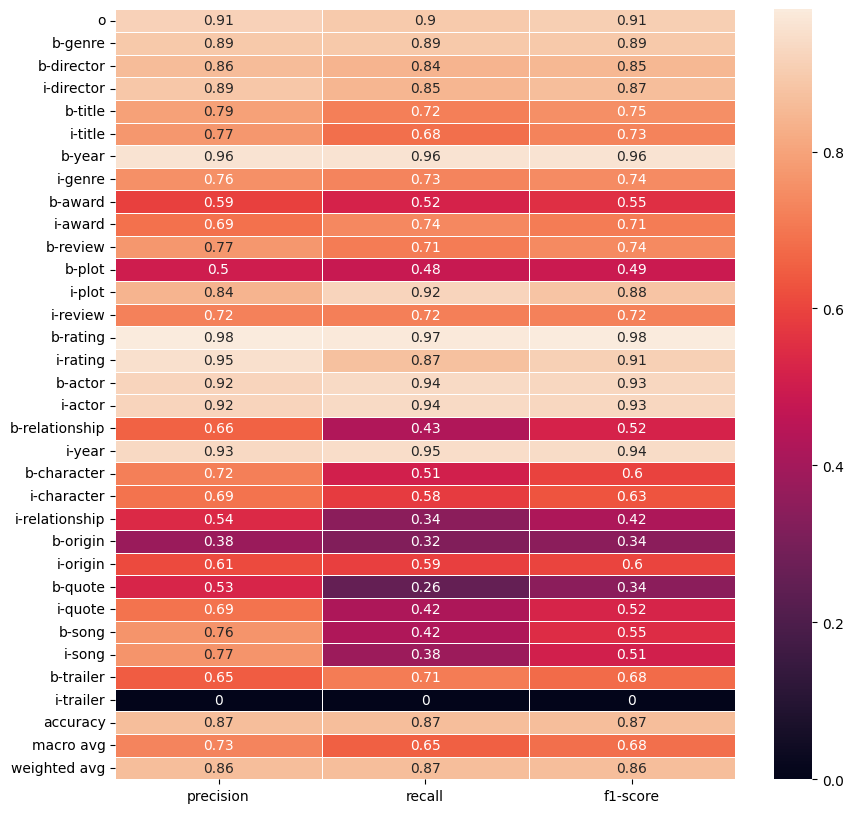

In [ ]:
# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)